In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from scipy.signal import medfilt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/filtered_data_new.csv')

In [ ]:
reshaped_data = pd.DataFrame({
    'RSSI': pd.concat([data['Empty Room'], data['RUNNING'], data['SITTING'], data['Walking']]),
    'Activity': ['Empty Room'] * len(data) + ['Running'] * len(data) + ['Sitting'] * len(data) + ['Walking'] * len(data)
})

In [ ]:
smote = SMOTE()
X, y = smote.fit_resample(reshaped_data[['RSSI']], reshaped_data['Activity'])

In [ ]:
reshaped_data['RSSI'] = medfilt(reshaped_data['RSSI'], kernel_size=3)

In [ ]:
imputer = SimpleImputer(strategy='median')
reshaped_data['RSSI'] = imputer.fit_transform(reshaped_data[['RSSI']])

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(reshaped_data['Activity'])
y_encoded = to_categorical(y_encoded)

In [ ]:
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


In [131]:
time_steps = 10
X_sequences, y_sequences = create_sequences(X, y_encoded, time_steps)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [133]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

In [134]:
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [135]:
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(64))
model.add(Dropout(0.3))


In [136]:
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [137]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=256, verbose=2)

Epoch 1/50
217/217 - 31s - 143ms/step - accuracy: 0.8010 - loss: 0.4683 - val_accuracy: 0.8983 - val_loss: 0.2682
Epoch 2/50
217/217 - 12s - 54ms/step - accuracy: 0.8879 - loss: 0.2901 - val_accuracy: 0.9023 - val_loss: 0.2503
Epoch 3/50
217/217 - 10s - 46ms/step - accuracy: 0.8979 - loss: 0.2620 - val_accuracy: 0.9072 - val_loss: 0.2400
Epoch 4/50
217/217 - 8s - 38ms/step - accuracy: 0.9011 - loss: 0.2542 - val_accuracy: 0.9093 - val_loss: 0.2355
Epoch 5/50
217/217 - 10s - 48ms/step - accuracy: 0.9068 - loss: 0.2434 - val_accuracy: 0.9149 - val_loss: 0.2245
Epoch 6/50
217/217 - 10s - 48ms/step - accuracy: 0.9089 - loss: 0.2397 - val_accuracy: 0.9192 - val_loss: 0.2218
Epoch 7/50
217/217 - 18s - 85ms/step - accuracy: 0.9096 - loss: 0.2356 - val_accuracy: 0.9197 - val_loss: 0.2191
Epoch 8/50
217/217 - 12s - 55ms/step - accuracy: 0.9099 - loss: 0.2379 - val_accuracy: 0.9113 - val_loss: 0.2293
Epoch 9/50
217/217 - 10s - 47ms/step - accuracy: 0.9124 - loss: 0.2314 - val_accuracy: 0.9173 - 

In [138]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'CNN + LSTM Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
CNN + LSTM Accuracy: 93.74%
              precision    recall  f1-score   support

  Empty Room       0.91      0.99      0.95      3797
     Running       0.95      0.91      0.93      3923
     Sitting       0.97      0.90      0.93      3859
     Walking       0.93      0.95      0.94      3807

    accuracy                           0.94     15386
   macro avg       0.94      0.94      0.94     15386
weighted avg       0.94      0.94      0.94     15386



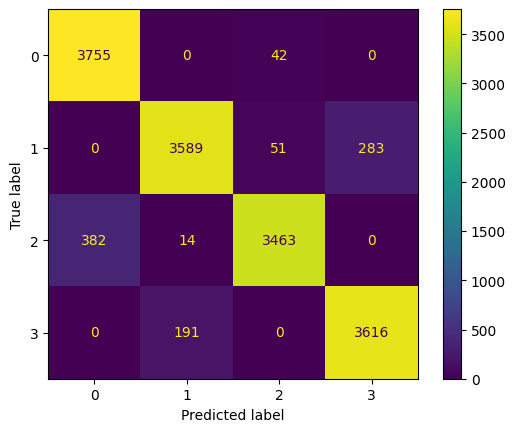

In [139]:
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [141]:
print(X_sequences)

[[[58.25]
  [58.25]
  [58.75]
  ...
  [58.75]
  [58.75]
  [58.5 ]]

 [[58.25]
  [58.75]
  [58.75]
  ...
  [58.75]
  [58.5 ]
  [58.  ]]

 [[58.75]
  [58.75]
  [58.  ]
  ...
  [58.5 ]
  [58.  ]
  [58.  ]]

 ...

 [[67.  ]
  [67.  ]
  [67.  ]
  ...
  [69.  ]
  [65.  ]
  [65.  ]]

 [[67.  ]
  [67.  ]
  [66.  ]
  ...
  [65.  ]
  [65.  ]
  [65.  ]]

 [[67.  ]
  [66.  ]
  [65.  ]
  ...
  [65.  ]
  [65.  ]
  [69.  ]]]
